In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [2]:
labels = pd.read_csv('Data/upvote_features.txt', header=None)
X = pd.read_csv('Data/upvote_data.csv', header=None)
y = pd.read_csv('Data/upvote_labels.txt', header=None)

## Problem 1a

In [3]:
X_mod = X.copy()
# X_mod.insert(0,'bias',1)
X_mod.columns = range(X_mod.columns.size)

In [4]:
train_x,train_y = X_mod.loc[:3999,:].values,y.loc[:3999,:].values
test_x,test_y = X_mod.loc[4000:,:].values,y.loc[4000:,:].values

In [5]:
def mse(predict,actual):
    return float(np.sum((np.reshape(actual,len(actual)) - predict)**2)/len(predict))

In [6]:
model = LinearRegression().fit(train_x,train_y)
pred = model.predict(train_x)
train_err = mse(pred,train_y)
print(f"Training Error: {train_err}")

Training Error: 1.4783154406474576e+17


In [7]:
pred = model.predict(test_x)
test_err = mse(pred,test_y)
print(f"Testing Error: {test_err}")

Testing Error: 7.340999667672971e+16


In [8]:
val_err = 0
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for train_idx, test_idx in kf.split(train_x):
    model = LinearRegression().fit(train_x[train_idx],train_y[train_idx])
    pred = model.predict(train_x[test_idx])
    val_err += mse(pred,train_y[test_idx])
val_err /= 5
print(f"Validation Error: {val_err}")

Validation Error: 4.680072490874591e+21


## Problem 1b

In [9]:
from sklearn import linear_model

In [10]:
train_x,train_y = X.loc[:3999,:],y.loc[:3999,:]
val_x,val_y = X.loc[4000:4999,:],y.loc[4000:4999,:]
test_x,test_y = X.loc[5000:,:],y.loc[5000:,:]

In [11]:
import warnings 
warnings.filterwarnings("ignore")

# reg_constant = np.logspace(-10,1,num=10)
reg_constant = [10**i for i in range(-10,1)]
coef = []
intercept = []
train_err = []
val_err = []
for reg in reg_constant:
    clf = linear_model.Lasso(alpha=reg,tol=3e-6,max_iter=1e4)
    clf.fit(train_x.to_numpy(), train_y.to_numpy())
    train_err.append(mse(clf.predict(train_x.to_numpy()), train_y.to_numpy()))
    val_err.append(mse(clf.predict(val_x.to_numpy()), val_y.to_numpy()))
    intercept.append(clf.intercept_)
    coef.append(clf.coef_)

Text(0, 0.5, 'Error')

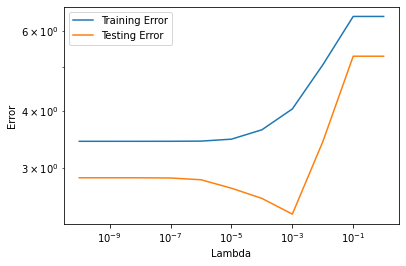

In [25]:
%matplotlib inline
plt.loglog(reg_constant, train_err, label='Training Error')
plt.loglog(reg_constant, val_err, label='Testing Error')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Error')

In [13]:
alpha=1e-7

clf = linear_model.Lasso(alpha=alpha,tol=3e-6,max_iter=1e4)
clf.fit(test_x.to_numpy(), test_y.to_numpy())
print(f"Test Error for lambda = {alpha}: {mse(clf.predict(test_x.to_numpy()), test_y.to_numpy())}")

Test Error for lambda = 1e-07: 2.465753626186577


## Problem 1c

In [14]:
from tensorflow import keras

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import L1

from sklearn.preprocessing import StandardScaler

SEED = 1

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [16]:
alpha=1e-3

In [17]:
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], kernel_regularizer=L1(l1=alpha), activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(1024, kernel_regularizer=L1(l1=alpha), activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(1, kernel_regularizer=L1(l1=alpha), activation='linear'))

model.compile(loss='mse', optimizer="adam", metrics=['accuracy']) 

2022-05-06 14:31:12.195864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-06 14:31:12.200004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-05-06 14:31:12.200459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-06 14:31:12.200472: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the req

In [18]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=2)]

In [19]:
batch_size = 128
n_epochs = 200

In [20]:
model.fit(X_train.values, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2,     
             verbose=2, callbacks=callbacks)

Epoch 1/200
30/30 - 1s - loss: 7.4835 - accuracy: 0.4112 - val_loss: 7.1940 - val_accuracy: 0.3990 - 749ms/epoch - 25ms/step
Epoch 2/200
30/30 - 0s - loss: 5.8441 - accuracy: 0.2828 - val_loss: 6.7690 - val_accuracy: 0.3115 - 114ms/epoch - 4ms/step
Epoch 3/200
30/30 - 0s - loss: 5.6844 - accuracy: 0.2724 - val_loss: 6.6329 - val_accuracy: 0.3115 - 122ms/epoch - 4ms/step
Epoch 4/200
30/30 - 0s - loss: 5.6819 - accuracy: 0.2724 - val_loss: 6.6193 - val_accuracy: 0.3115 - 115ms/epoch - 4ms/step
Epoch 5/200
30/30 - 0s - loss: 5.5243 - accuracy: 0.2724 - val_loss: 6.5552 - val_accuracy: 0.3115 - 112ms/epoch - 4ms/step
Epoch 6/200
30/30 - 0s - loss: 5.4666 - accuracy: 0.2724 - val_loss: 6.4845 - val_accuracy: 0.3115 - 109ms/epoch - 4ms/step
Epoch 7/200
30/30 - 0s - loss: 5.3426 - accuracy: 0.2724 - val_loss: 6.6404 - val_accuracy: 0.3115 - 110ms/epoch - 4ms/step
Epoch 8/200
30/30 - 0s - loss: 5.6060 - accuracy: 0.2724 - val_loss: 6.5521 - val_accuracy: 0.3115 - 117ms/epoch - 4ms/step
Epoch 9

In [21]:
score = model.evaluate(X_test.values, y_test)
print('Test accuracy: %.2f%%' % (score[1]*100))
print('Test MSE: %.2f' % (score[0]))

38/38 [==============================] - 0s 1ms/step - loss: 3.3966 - accuracy: 0.2908
Test accuracy: 29.08%
Test MSE: 3.40


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 1001      
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2048      
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 4,074
Trainable params: 4,074
Non-trainable params: 0
_________________________________________________________________
